In [32]:
import torch
import numpy as np
%load_ext autoreload
%autoreload 2
from utils1 import load_data,default_loader,trainset,imshow,normal,layershow
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from torchsummary import summary
import time,datetime
from scipy.integrate import solve_ivp
from bokeh.io import  output_notebook, push_notebook, show
from bokeh.plotting import figure
from bokeh.layouts import column, row
from bokeh.models import Label
from ipywidgets import interact, FloatSlider
from bokeh.palettes import Category10, Category20
output_notebook(hide_banner=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Data Path**

In [33]:
datapath = "./datasets"
datapath = "/home/tete/data/Youtube"
data,paths,labels = load_data(datapath)
available_field = ['url','videoname','locs','frameids','label_names','crop','scale','origRes','isYouTubeSubset']


**shift the data**

In [34]:
num_data=len(paths)
index=np.arange(num_data)
np.random.shuffle(index)
paths=[paths[i] for i in index]
labels=[labels[i] for i in index]

**partition of the data into three part**

In [35]:
#how many data we will put into each set
train_num,val_num, test_num  = int(0.7*num_data),int(num_data*0.1),int(num_data*0.2)
new_w,new_h=224,224

assert(train_num+val_num+test_num<=num_data)
train_path,train_label=paths[0:train_num],labels[0:train_num]
val_path,  val_label  =paths[train_num:train_num+val_num],labels[train_num:train_num+val_num]
test_path, test_label =paths[train_num+val_num:],labels[train_num+val_num:]
bc=8

train_data  = trainset(train_path,train_label,new_w,new_h)
trainloader = DataLoader(train_data, batch_size=bc,shuffle=True)

val_data  = trainset(val_path,val_label,new_w,new_h)
valloader = DataLoader(val_data, batch_size=bc,shuffle=True)

test_data  = trainset(test_path,test_label,new_w,new_h)
testloader = DataLoader(test_data, batch_size=bc,shuffle=True)
print("number of data in the training set    :", len(train_data))
print("number of data in the validation set  :", len(val_data))
print("number of data in the test set        :", len(test_data))

number of data in the training set    : 3500
number of data in the validation set  : 500
number of data in the test set        : 1000


In [36]:
train_data[0][1]

tensor([[132.8846,  48.9849],
        [107.6156, 106.9939],
        [131.3151, 112.0163],
        [111.5393, 138.8863],
        [150.6201, 143.9087],
        [123.1537,  83.3885],
        [158.4676,  82.3840]])

**load example data from test set**

In [37]:
count = 1
for data in testloader:
    if count == 1:
        inputs_try,labels_try = data
    count +=1
print(count,"batches")   
print(inputs_try.shape)
print(labels_try.shape)

126 batches
torch.Size([8, 3, 224, 224])
torch.Size([8, 7, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


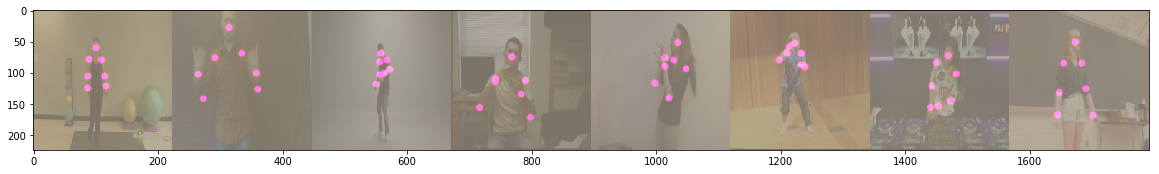

In [38]:
out = torchvision.utils.make_grid(inputs_try,padding=0)
imshow(out,[224,224],labels_try) 

In [39]:
use_gpu=torch.cuda.is_available()
use_gpu

True

In [40]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1), 
            nn.ReLU(True),
            nn.BatchNorm2d(16),
            #nn.MaxPool2d(2, stride=2), 
            
            nn.Conv2d(16, 32, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.Conv2d(32, 32, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, stride=2),  
            
            nn.Conv2d(32, 64, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.Conv2d(64, 64, 3, stride=1, padding=1), 
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, stride=2),
            
            
            nn.Conv2d(64, 128, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout2d(p=0.25),
            
            
            nn.Conv2d(128, 256, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout2d(p=0.25),
            
            
            nn.Conv2d(256, 512, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, stride=2),
            
        )
        self.drop1=nn.Dropout(p=0.5)
        #self.fn1=nn.Linear(512*5*5,7)
        self.fn1=nn.Linear(1024,128)
        self.fn2=nn.Linear(128,7)
    def forward(self, x):
        #x=self.seq(x)
        x=x.view(-1,2,1024)
        #x=self.drop1(x)
        x=self.fn1(x)
        x=self.fn2(x)
        x=x.reshape(-1,7,2)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = Regressor().to(device)
#summary(model, (3, 180, 320))

In [41]:
model_res = torchvision.models.resnet152(pretrained=True )

In [42]:
model_res

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [43]:
model_res.fc = Regressor()

In [44]:
def train(model,trainloader,loss_fn,optimizer):
    if use_gpu:
        model=model.to("cuda")
        
    model.train(True)
    optimizer = optimizer

    running_corrects = 0.0
    running_loss = 0.0
    size = 0
    for data in trainloader:
        inputs, labels = data
        bs = labels.size(0)

        if use_gpu:
            inputs=inputs.cuda()
            labels=labels.cuda()


        outputs = model(inputs)
        #print(outputs.shape, labels.shape)
        loss = loss_fn(outputs,labels) 
        
        sum_loss = torch.sum(loss,dim=2)
        sqrt_loss = torch.sqrt(sum_loss)
        sum_loss2 = torch.sum(sqrt_loss)
        
        optimizer.zero_grad()
        sum_loss2.backward()
        optimizer.step()

        #running_loss+=loss.data.item()
        #_,preds = torch.max(outputs.data,1)
        preds=outputs.data
        # statistics
        running_loss += sum_loss2.data.item()
        #print(preds.shape,labels.shape)
        #running_corrects += torch.sum(preds == labels)

        if(size%int(len(trainloader)/5)==0 and size!=0):
            print(running_loss / size, size)
        size += bs
              
            
    epoch_loss = running_loss / size

    #acc_train[epoch_num] = epoch_acc
    #print( 'Train - Loss: {:.4f}'.format(epoch_loss))
        
    return epoch_loss


In [45]:
plot_distance = 125
labels = ['Head', 'Right wrist', 'Left wrist', 'Right elbow', 'Left elbow', 'Right shoulder', 'Left shoulder']
def print_figure(distance):
    fig_sol = figure(x_range=(0, plot_distance), width=650, height=300, title="Solution")
    for i in range(7):
        d = distance[:,i]
        length_d = len(d)
        np.append(d,[plot_distance])
        counter = 0
        acc = []
        for j in range(plot_distance):
            while(counter<length_d and d[counter]<j):
                counter = counter+1
            acc.append(1.0*counter/length_d)
        fig_sol.line(range(plot_distance),acc,legend=labels[i],line_width=2,color=Category10[10][i])
    fig_sol.legend.location = "bottom_right"
    show(fig_sol)
            

In [51]:
def test(model,data_loader,loss_fn,optimizer):
    model.eval()
    if use_gpu:
        model=model.to("cuda")
    running_corrects = 0.0
    running_loss = 0.0
    size = 0
    distance = []
    with torch.no_grad():

        for data in data_loader:
            inputs, labels = data    
            bs = labels.size(0)

            if use_gpu:
                inputs=inputs.cuda()
                labels=labels.cuda()

            outputs = model(inputs)
            loss = loss_fn(outputs,labels)
            
            sum_loss = torch.sum(loss,dim=2)
            sqrt_loss = torch.sqrt(sum_loss)
            distance.extend(sqrt_loss.cpu().numpy())
            
            sum_loss2 = torch.sum(sqrt_loss)
            #print(ave_loss.shape)
            #running_loss+=loss.data.item()
            #_,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += sum_loss2.data.item()
            #running_corrects += torch.sum(preds == labels)
            size += bs
        
        out = torchvision.utils.make_grid(inputs_try.cpu(),padding=0)
        preds=model(inputs_try.cuda()).cpu()
        imshow(out,[224,224],preds.cpu())
        
        epoch_loss = running_loss / size
    distance = np.array(distance)
    distance.sort(axis=0)
   #print(distance[:,0])
    print_figure(distance)
    return epoch_loss

In [48]:
pose_detection = model_res
# choose the appropriate loss
loss_fn = nn.MSELoss(reduction='none')
#loss_fn = nn.MSELoss(reduction='sum')
learning_rate = 1.0
# your SGD optimizer
#optimizer_cl = torch.optim.Adadelta(pose_detection.parameters(),lr = learning_rate)

parameters = []
parameters.append({ "params": pose_detection.fc.parameters()})
parameters.append({ "params": pose_detection.layer4.parameters()})

optimizer = torch.optim.Adadelta(parameters,lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
# and train for 10 epochs
l_t,l_v=[],[]

37.538074559178845 696
36.66161891235702 1392
36.283956191548896 2088
36.56447855083422 2784
36.27811597188314 3480


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


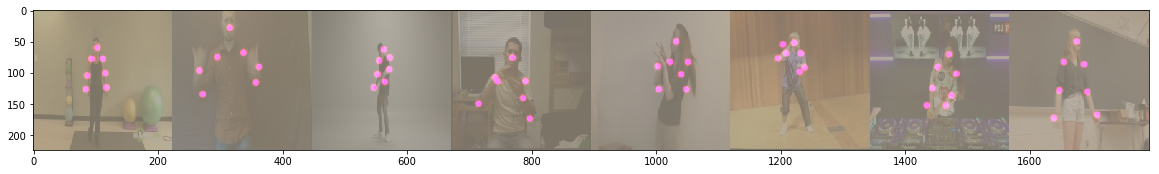

Epoch: 1  Train - Loss: 36.18 ; Validation - Loss: 42.17
Time consumed: 0:02:44.838829 Remaining time: 0:24:43.549461
35.77700003262224 696
35.399761254760044 1392
35.51256604395607 2088
35.11517876044087 2784
35.069362925386976 3480


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


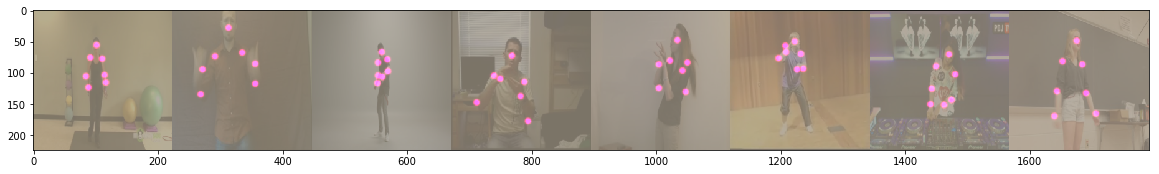

Epoch: 2  Train - Loss: 35.00 ; Validation - Loss: 40.89
Time consumed: 0:05:30.545038 Remaining time: 0:22:02.180150
31.2671693166097 696
30.643181614492132 1392
30.175429106672148 2088
30.408028767026703 2784
30.229531505190092 3480


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


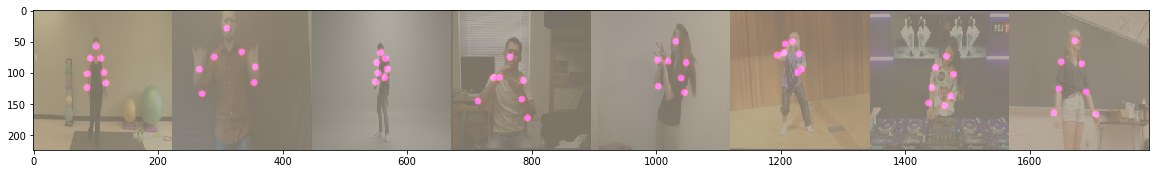

Epoch: 3  Train - Loss: 30.16 ; Validation - Loss: 40.17
Time consumed: 0:08:15.845978 Remaining time: 0:19:16.973949
28.906847657828497 696
28.706270623481135 1392
28.899634182224784 2088
28.866754383876405 2784
28.88434796388122 3480


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


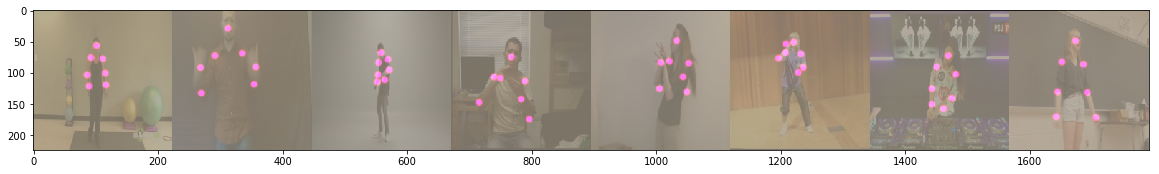

Epoch: 4  Train - Loss: 28.87 ; Validation - Loss: 37.65
Time consumed: 0:11:00.712805 Remaining time: 0:16:31.069207
30.138480986671887 696
29.14796555179289 1392
28.783878443341603 2088
28.587980911649506 2784
28.223641520533068 3480


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


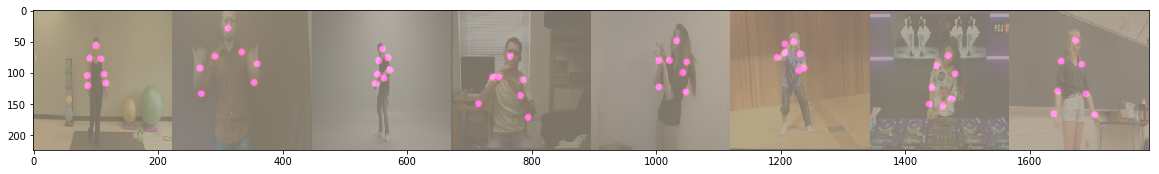

Epoch: 5  Train - Loss: 28.18 ; Validation - Loss: 38.58
Time consumed: 0:13:45.984227 Remaining time: 0:13:45.984227
28.31012412323349 696
27.541549474343487 1392
27.128614089498118 2088
27.45650992996391 2784
27.402850069944886 3480


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


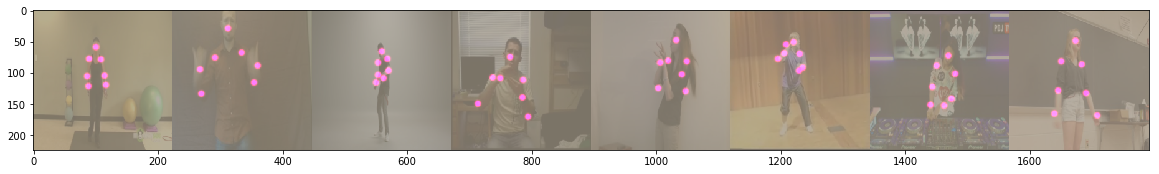

Epoch: 6  Train - Loss: 27.34 ; Validation - Loss: 37.22
Time consumed: 0:16:30.754550 Remaining time: 0:11:00.503034
27.00704504429609 696
27.153996478552106 1392
26.821939212609067 2088
26.68549561226505 2784
26.791438854699848 3480


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


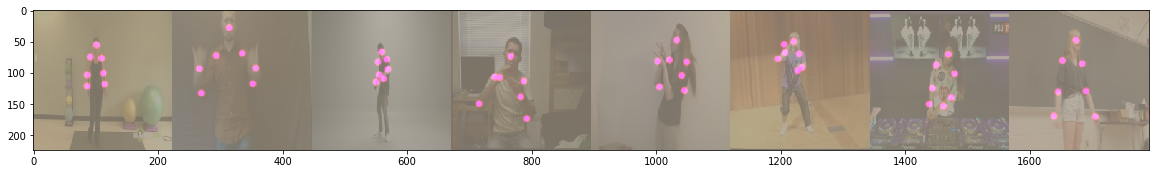

Epoch: 7  Train - Loss: 26.72 ; Validation - Loss: 37.98
Time consumed: 0:19:16.400200 Remaining time: 0:08:15.600086
25.17804606207486 696
24.752153374682898 1392
24.379532444979496 2088
24.725403895323304 2784
24.654133307796783 3480


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


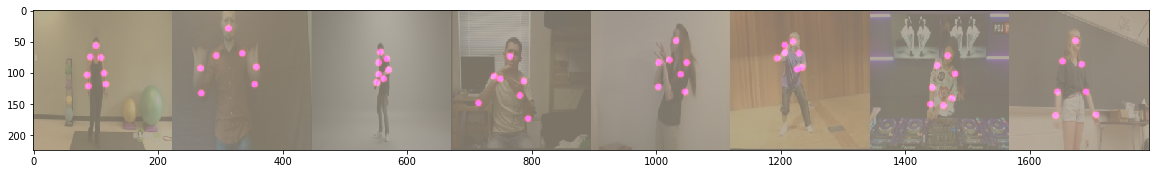

Epoch: 8  Train - Loss: 24.61 ; Validation - Loss: 36.63
Time consumed: 0:22:02.007772 Remaining time: 0:05:30.501943
23.86569384870858 696
23.72358837346921 1392
24.23465067399416 2088
24.260574247645234 2784
24.12319434154993 3480


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


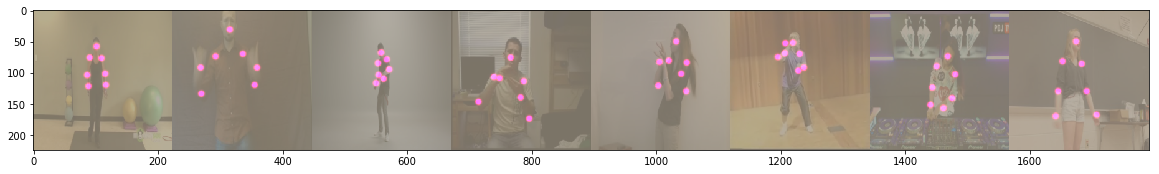

Epoch: 9  Train - Loss: 24.08 ; Validation - Loss: 36.32
Time consumed: 0:24:47.011255 Remaining time: 0:02:45.223473
23.25252318108219 696
23.482614374708856 1392
23.276192573751985 2088
23.38766669678962 2784
23.424703453327048 3480


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


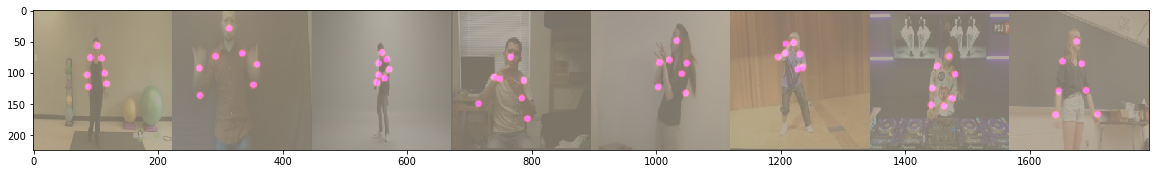

Epoch: 10  Train - Loss: 23.38 ; Validation - Loss: 36.20
Time consumed: 0:27:32.559510 Remaining time: 0:00:00


In [54]:
num_epoch=10

time_begin=time.time()

for epoch in range(num_epoch):
    scheduler.step()
    epoch_loss=train(pose_detection,trainloader,loss_fn,optimizer)
    val_loss  =test(pose_detection,valloader,loss_fn,optimizer)
    print('Epoch:',epoch+1, ' Train - Loss: {:.2f} ; Validation - Loss: {:.2f}'.format(epoch_loss,val_loss))
    l_t.append(epoch_loss)
    l_v.append(val_loss)
    now=time.time()
    time_used=now-time_begin
    time_remain= time_used /(epoch+1) *(num_epoch-1-epoch)
    print("Time consumed:", datetime.timedelta(seconds=time_used), "Remaining time:", datetime.timedelta(seconds=time_remain))
    
    

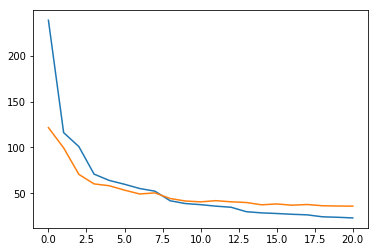

In [55]:
plt.plot(range(len(l_t)),l_t,l_v)

In [58]:
torch.save(pose_detection,"/home/tete/data/model")

/home/tete/anaconda3/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Regressor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [56]:
pose_detection.train(False)    
preds = pose_detection(inputs_try.cuda()).cpu()
print(preds.shape)
print(labels_try.shape)

torch.Size([8, 7, 2])
torch.Size([8, 7, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


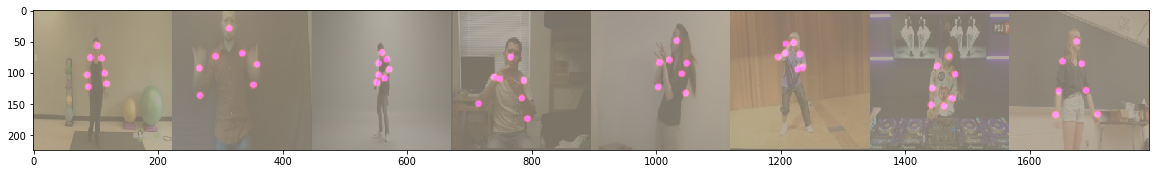

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


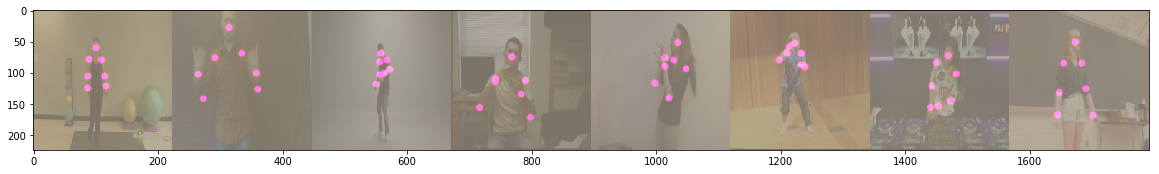

In [57]:
out = torchvision.utils.make_grid(inputs_try,padding=0)
imshow(out,[224,224],preds) 
imshow(out,[224,224],labels_try)

In [ ]:
def train(model,trainloader,loss_fn,optimizer,n_epochs=10):
    if use_gpu:
        model=model.to("cuda")
        
    model.train(True)
    
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    optimizer = optimizer
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    for epoch_num in range(n_epochs):
        scheduler.step()
        running_corrects = 0.0
        running_loss = 0.0
        size = 0
        for data in trainloader:
            inputs, labels = data
            bs = labels.size(0)
            
            if use_gpu:
                inputs=inputs.cuda()
                labels=labels.cuda()
            
            
            outputs = model(inputs)
            #print(outputs.shape, labels.shape)
            loss = loss_fn(outputs,labels) 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #running_loss+=loss.data.item()
            #_,preds = torch.max(outputs.data,1)
            preds=outputs.data
            # statistics
            running_loss += loss.data.item()
            #print(preds.shape,labels.shape)
            #running_corrects += torch.sum(preds == labels)
            
            #if(size%int(len(data_loader)/3)==0 and size!=0):
            #    print(running_loss / size, size)
            size += bs
              
            
        epoch_loss = running_loss / size
        #epoch_acc = running_corrects.item() / size
        loss_train[epoch_num] = epoch_loss
        #acc_train[epoch_num] = epoch_acc
        print('Epoch: ',epoch_num+1,'/',n_epochs,' Train - Loss: {:.4f}'.format(epoch_loss))
        
    return loss_train#, acc_train